# 생산부품 예측 LSTM pytorch
- 목표 : 부품 Part_Number 별로 D일 투입예정 수량(D일 계획) 예측

### 컬럼설명
- Part_Number : 협력기업에서 모기업에 납품해야하는 부품의 식별자 (id)
- CRET_TIME : 특정부품의 발주 수량이 기록된 해당 시각 정보
- D일 X~XH투입 계획 수량 : 당일(D일)의 시각별 발주 및 계획 발주량
- D일 투입 예정 수량 : 당일(D일)의 통합 발주 및 계획 발주량
- D+X일 투입 예정 수량 : 당일(D일)에 기록된 X일 이후의 계획 발주량

### 데이터 특징
- 데이터기간 : 2021-09-11 ~ 2021-11-01

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import trange
import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

pd.set_option('display.max_columns', None)

## 1. 전처리

In [33]:
df = pd.read_excel('./data.xls')

# 시간 일단위
df['CRET_TIME'] = df['CRET_TIME'].astype(str)
df['CRET_TIME'] = pd.to_datetime(df['CRET_TIME']).dt.date

# last
df = df.groupby(['Part Number', 'CRET_TIME']).last()
df = df.reset_index(drop=False)

# Part Number
df['Part Number'] = df['Part Number'].str.replace('Part', '')
df['Part Number'] = df['Part Number'].astype(int)

# index
df = df.sort_values('CRET_TIME')
df = df.set_index('CRET_TIME')
df

,Part Number,D일06~08(08)H 투입계획(발주) 수량,D일08~10(10)H 투입계획(발주) 수량,D일10~12(13)H 투입계획(발주) 수량,D일13~15(15)H 투입계획(발주) 수량,D일15~17(18)H 투입계획(발주) 수량,D일18~20(21)H 투입계획(발주) 수량,D일21~23(23)H 투입계획(발주) 수량,D일23~01(02)H 투입계획(발주) 수량,D일 02~04H 투입계획 수량,D일 04~06H 투입계획 수량,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(D+1일),D+1일 투입예정 수량(D+1일).1,D+1일 투입예정 수량(D+1일).2,D+1일 투입예정 수량(D+1일).3,D+1일 투입예정 수량(D+1일).4,D+1일 투입예정 수량(D+1일).5,D+1일 투입예정 수량(D+1일).6,D+1일 투입예정 수량(D+1일).7,D+1일 투입예정 수량(D+1일).8,D+1일 투입예정 수량(D+1일).9,D+1일 투입예정 수량(Total),D+2일 투입예정 수량(과부족수량),D+2일 투입예정 수량(과부족수량).1,D+2일 투입예정 수량(과부족수량).2,D+2일 투입예정 수량(과부족수량).3,D+2일 투입예정 수량(과부족수량).4,D+2일 투입예정 수량(과부족수량).5,D+2일 투입예정 수량(과부족수량).6,D+2일 투입예정 수량(과부족수량).7,D+2일 투입예정 수량(과부족수량).8,D+2일 투입예정 수량(과부족수량).9,D+2일 투입예정 수량(Total),D+3일 투입예정 수량(과부족수량),D+3일 투입예정 수량(과부족수량).1,D+3일 투입예정 수량(과부족수량).2,D+3일 투입예정 수량(과부족수량).3,D+3일 투입예정 수량(과부족수량).4,D+3일 투입예정 수량(과부족수량).5,D+3일 투입예정 수량(과부족수량).6,D+3일 투입예정 수량(과부족수량).7,D+3일 투입예정 수량(과부족수량).8,D+3일 투입예정 수량(과부족수량).9,D+3일 투입예정 수량(Total),D+4일 투입예정 수량(과부족수량),D+4일 투입예정 수량(과부족수량).1,D+4일 투입예정 수량(과부족수량).2,D+4일 투입예정 수량(과부족수량).3,D+4일 투입예정 수량(과부족수량).4,D+4일 투입예정 수량(과부족수량).5,D+4일 투입예정 수량(과부족수량).6,D+4일 투입예정 수량(과부족수량).7,D+4일 투입예정 수량(과부족수량).8,D+4일 투입예정 수량(과부족수량).9,D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량,D+13일 투입예정 수량,D+14일 투입예정 수량,D+15일 투입예정 수량,D+16일 투입예정 수량,D+17일 투입예정 수량,D+18일 투입예정 수량,D+19일 투입예정 수량,D+20일 투입예정 수량,D+21일 투입예정 수량,D+22일 투입예정 수량,D+23일 투입예정 수량,D+24일 투입예정 수량,D+25일 투입예정 수량,D+26일 투입예정 수량,D+27일 투입예정 수량,D+28일 투입예정 수량,D+29일 투입예정 수량,D+30일 투입예정 수량,D+31~D+45일 투입예정 수량
CRET_TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-13,18,40,10,23,23,23,27,21,13,0,0,180,20,8,13,15,14,21,15,11,0,0,117,17,12,18,15,14,19,12,10,0,0,117,19,7,20,17,15,13,20,14,0,0,125,15,23,31,26,23,31,23,15,0,0,187,152,0,148,177,186,182,158,0,0,171,177,173,175,239,0,0,258,283,220,20,11,0,0,0,0,0,0
2021-09-13,19,4,13,8,3,0,4,2,2,0,0,36,8,15,18,11,9,10,8,4,0,0,83,11,11,13,11,9,12,11,5,0,0,83,9,16,11,9,8,18,3,1,0,0,75,7,0,0,0,0,0,0,0,0,0,7,48,0,52,14,0,3,29,0,0,3,1,14,15,13,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-13,88,1,0,0,0,0,0,0,3,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,0,0,0,1,0,1,3,0,0,7,0,0,59,199,242,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-13,2,139,60,80,76,68,81,68,44,0,0,616,71,66,84,76,61,90,66,46,0,0,560,75,67,101,63,70,100,72,42,0,0,590,88,72,93,73,69,75,71,47,0,0,588,74,58,88,74,60,77,69,32,0,0,532,0,0,451,523,533,675,855,0,0,877,645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,3,11,5,9,8,7,9,7,4,0,0,60,8,8,9,9,8,10,7,5,0,0,64,10,8,9,9,8,4,5,5,0,0,58,8,7,9,8,8,8,7,5,0,0,60,8,6,9,7,7,9,7,4,0,0,57,62,0,85,79,94,90,43,66,0,104,51,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-01,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,3,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-01,20,4,2,0,2,3,0,1,2,0,0,14,0,4,2,2,2,3,2,2,0,0,17,2,0,4,0,2,2,4,0,0,0,14,1,2,7,5,2,4,0,3,0,0,24,4,5,5,2,2,3,1,0,0,0,22,0,0,16,24,23,47,37,0,0,27,74,62,19,14,0,0,16,29,0,0,0,0,0,0,0,0,0


In [34]:
df = df[['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)', 'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량',
       'D+6일 투입예정 수량', 'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량',
       # 'D+10일 투입예정 수량', 'D+11일 투입예정 수량', 'D+12일 투입예정 수량', 'D+13일 투입예정 수량',
       # 'D+14일 투입예정 수량', 'D+15일 투입예정 수량', 'D+16일 투입예정 수량', 'D+17일 투입예정 수량',
       # 'D+18일 투입예정 수량', 'D+19일 투입예정 수량', 'D+20일 투입예정 수량', 'D+21일 투입예정 수량',
       # 'D+22일 투입예정 수량', 'D+23일 투입예정 수량', 'D+24일 투입예정 수량', 'D+25일 투입예정 수량',
       # 'D+26일 투입예정 수량', 'D+27일 투입예정 수량', 'D+28일 투입예정 수량', 'D+29일 투입예정 수량',
       # 'D+30일 투입예정 수량', 'D+31~D+45일 투입예정 수량'
        ]]

df

,Part Number,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(Total),D+2일 투입예정 수량(Total),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량
CRET_TIME,,,,,,,,,,,
2021-09-13,0,0,0,0,0,0,0,0,0,2,6
2021-09-13,18,180,117,117,125,187,152,0,148,177,186
2021-09-13,19,36,83,83,75,7,48,0,52,14,0
2021-09-13,88,4,0,0,2,7,0,0,59,199,242
2021-09-13,2,616,560,590,588,532,0,0,451,523,533
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,3,60,64,58,60,57,62,0,85,79,94
2021-11-01,46,0,0,0,3,2,0,0,0,0,0
2021-11-01,20,14,17,14,24,22,0,0,16,24,23


In [35]:
# part 별로 df 따로 만들기
part_num = len(df['Part Number'].sort_values().unique())
print(part_num)

for i in range(part_num):
    globals()[f'df{i}'] = df[df['Part Number']==i]

117


## 2. 모델 학습 LSTM many to single

In [37]:
def data_split(df):
    X = df.drop('D일 투입예정 수량(D일계획)', axis=1)
    y = df['D일 투입예정 수량(D일계획)']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    return X_train, X_test, y_train, y_test

In [38]:
def scaling(X_train, X_test):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [39]:
# 모델에서 사용할 시퀀스 생성 (차수변경, time_steps=3일)
def create_sequences(X, y, time_steps=3):
    X_list = []
    y_list = []
   
    for i in range(len(X) - time_steps):
        
        X_list.append(X[i : (i + time_steps)])
        y_list.append(y[i+time_steps])
        
    return np.stack(X_list), np.stack(y_list)

In [40]:
def create_model(X_train):
    model = Sequential()
    model.add(LSTM(32,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   activation='relu',
                   return_sequences=True
                  ))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(Dense(1))
  
    return model

In [41]:
def model_compile(i, model, X_train, y_train):
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    path = './models'
    os.makedirs(path, exist_ok=True)
    filename = os.path.join(f'./models/df{i}_lstm.h5')
    
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='auto')
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=8,
                        validation_split=0.1,
                        shuffle = False,
                        callbacks=[early_stop, checkpoint],
                        verbose=0
                        
                       )
    return model, filename, history

In [42]:
def model_pred(model, X_test, y_test, filename):
    model.evaluate(X_test, y_test, verbose=0)
    model.load_weights(filename)
    y_pred = model.predict(X_test, verbose=0)
    return y_pred

In [51]:
model_list = []
mse_list = []

# for i in trange(part_num):
for i in range(10):
    X_train, X_test, y_train, y_test = data_split(globals()[f'df{i}'])
    X_train_scaled, X_test_scaled = scaling(X_train, X_test)
    X_train_reshaped, y_train = create_sequences(X_train_scaled, y_train)
    X_test_reshaped, y_test = create_sequences(X_test_scaled, y_test)
        
    model = create_model(X_test_reshaped)
    model, filename, history = model_compile(i, model, X_train_reshaped, y_train)
    y_pred = model_pred(model, X_test_reshaped, y_test, filename)
    
    model_list.append(filename[9:-3])
    mse_list.append(np.min(history.history['val_loss']))

In [52]:
df_result = pd.DataFrame({'model':model_list,
                          'rmse':np.sqrt(mse_list)
                         })
df_result['rmse'] = round(df_result['rmse'].astype(float), ndigits=6)
df_result

,model,rmse
0,df0_lstm,0.007637
1,df1_lstm,0.003117
2,df2_lstm,22.075228
3,df3_lstm,0.008294
4,df4_lstm,70.192043
5,df5_lstm,49.677466
6,df6_lstm,8.148790
7,df7_lstm,3.002582
8,df8_lstm,2.993052
9,df9_lstm,2.894605


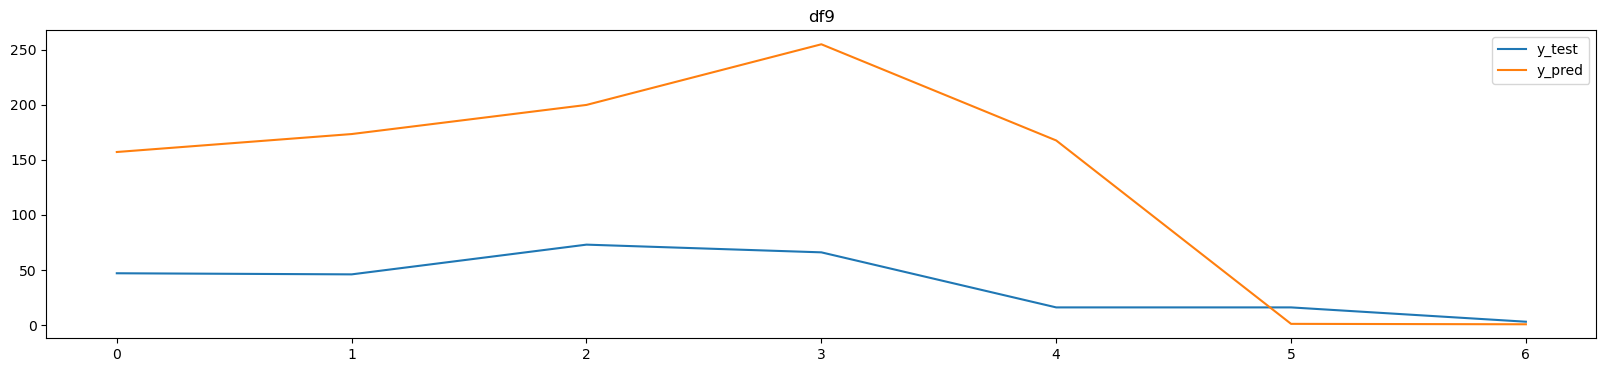

In [53]:
plt.figure(figsize=(20, 4))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.title(f'df{i}')
plt.legend()
plt.show()

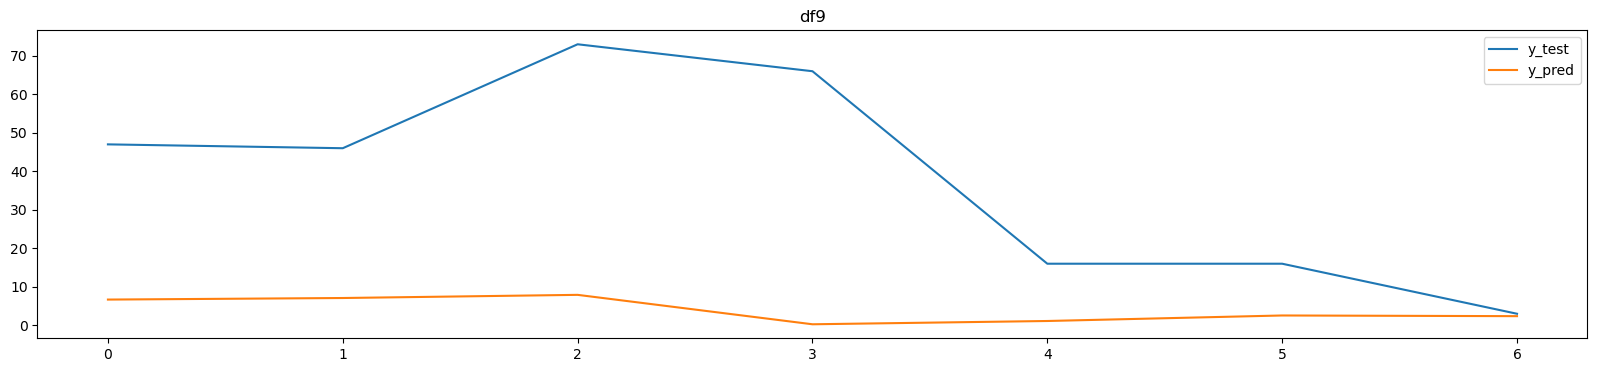

In [50]:
plt.figure(figsize=(20, 4))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.title(f'df{i}')
plt.legend()
plt.show()

## 3. LSTM many to many (ing...)

In [15]:
time_steps = 5

In [16]:
def train_test(df):
    df_train = df.iloc[:int(len(df)*0.8), :]
    df_test =  df.iloc[int(len(df)*0.8):, :]
    return df_train, df_test

In [17]:
def scaled(df_train, df_test):
    scaling = MinMaxScaler()
    df_train = scaling.fit_transform(df_train)
    df_test = scaling.transform(df_test)
    
    # df_train = np.log1p(df_train)
    # df_test = np.log1p(df_test)
    return df_train, df_test

In [18]:
# 모델에서 사용할 시퀀스 생성 (차수변경, time_steps=?일)
def create_sequences(df, time_steps=time_steps):
    
    arr = df.to_numpy().flatten()
    # arr = df.flatten()
    
    cnt=0
   
    for i in range(len(df) - (2*time_steps)+1):
        cnt += 1 # 샘플 숫자, reshape할 때 사용
        
        X_start = i
        X_end = i+time_steps
        y_start = i+time_steps
        y_end = i+(2*time_steps)
        
        if i==0:
            X = arr[X_start:X_end]
            y = arr[y_start:y_end]
        else:
            X = np.append(X, arr[X_start:X_end])
            y = np.append(y, arr[y_start:y_end])
        
        X = np.reshape(X, (cnt, time_steps, 1))
        y = np.reshape(y, (cnt, time_steps, 1))
        
    return X, y

In [19]:
def create_model(X_train):
    model = Sequential()
    model.add(LSTM(64,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   activation='relu'
                  ))
    model.add(RepeatVector(time_steps)) # many to many
    # model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1, activation='linear'))) # many to many
    
    # print(model.summary())
  
    return model

In [20]:
def result_vi(df_test, y_pred):
    plt.figure(figsize=(20, 4))
    plt.plot(df_test.index, df_test['D일 투입예정 수량(D일계획)'], label='test')
    plt.plot(df_test.index[-time_steps:], y_pred.flatten()*10, label='y_pred')
    plt.title(f'df{i}')
    plt.legend()
    plt.show()

In [21]:
def vi(y_test, y_pred):
    plt.figure(figsize=(20, 4))
    plt.plot(y_test.flatten(), label='y_test')
    plt.plot(y_pred.flatten(), label='y_pred')
    plt.title(f'df{i}')
    plt.legend()
    plt.show()

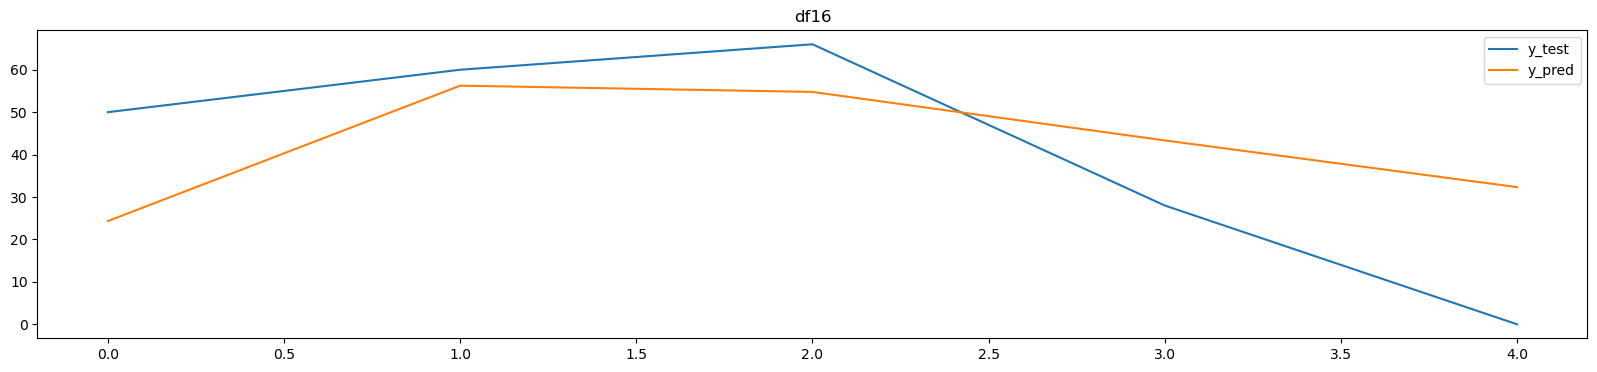

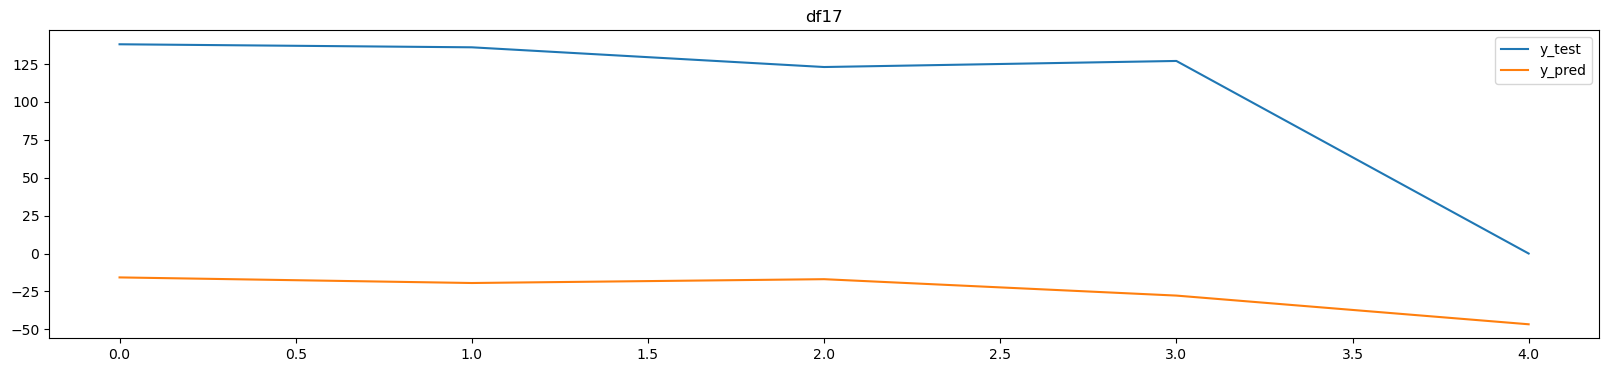

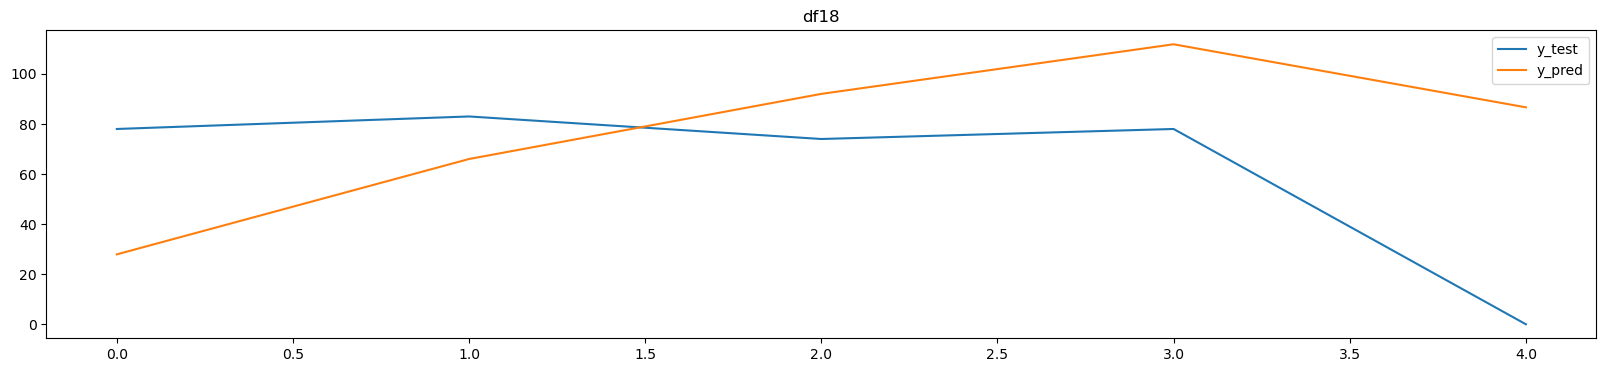

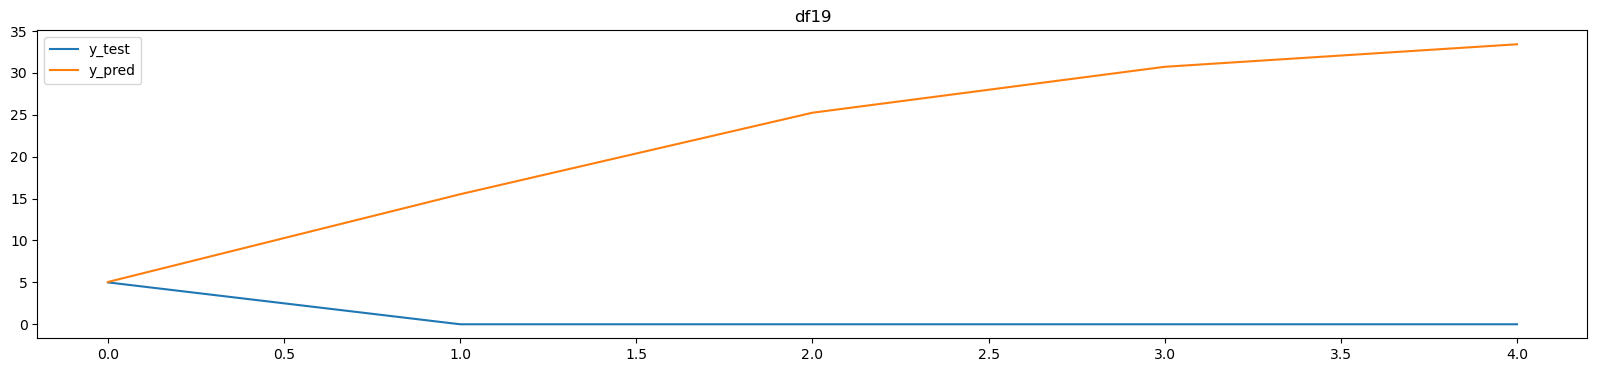

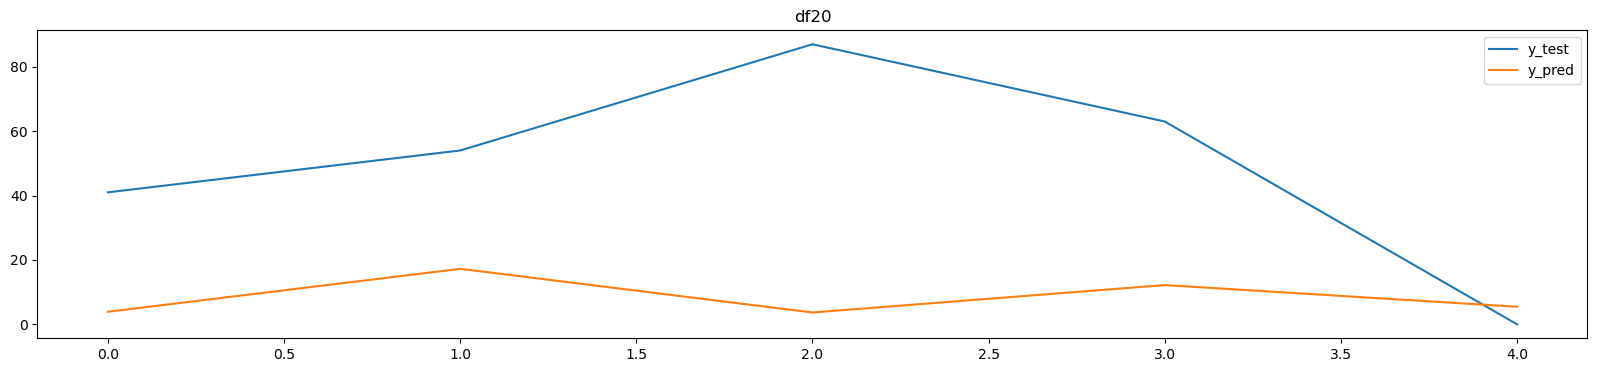

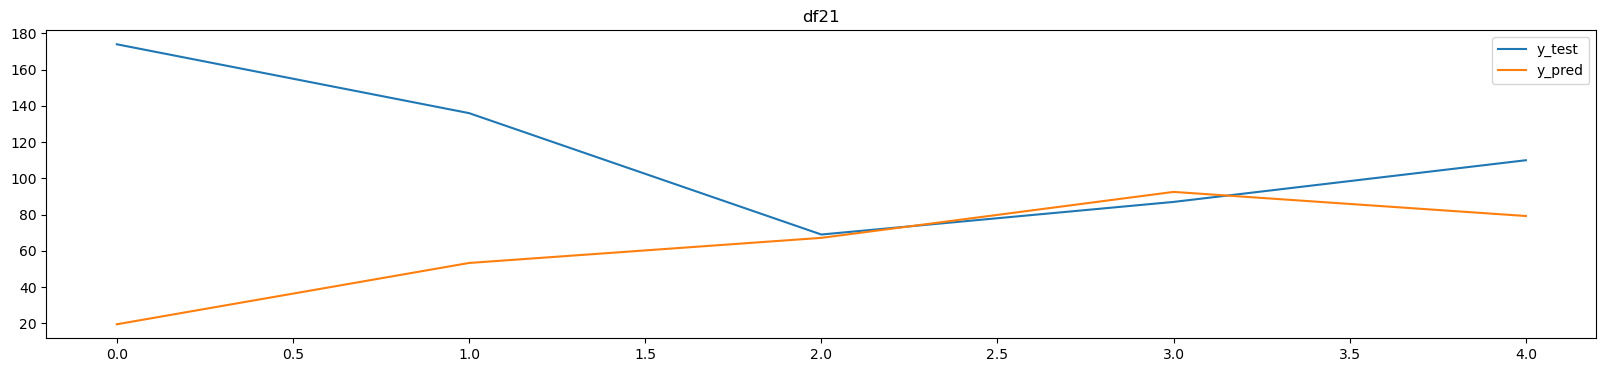

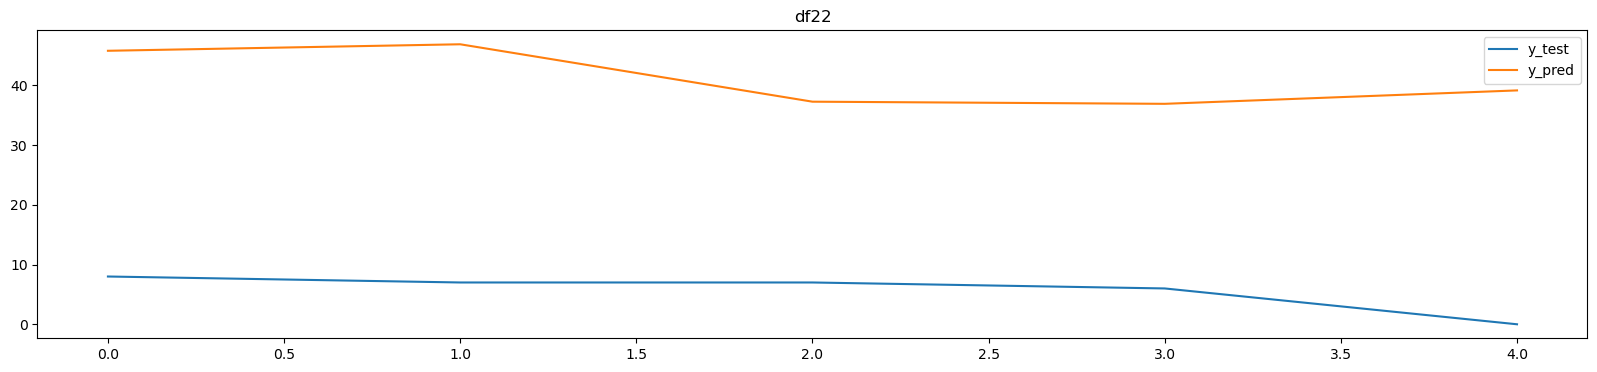

UnboundLocalError: local variable 'X' referenced before assignment

In [22]:
model_list = []
mse_list = []

# for i in trange(part_num):
for i in range(16, 26):
    df_train, df_test = train_test(globals()[f'df{i}'])
    # train_scaled, test_scaled = scaled(df_train, df_test)
    X_train, y_train = create_sequences(df_train)
    X_test, y_test = create_sequences(df_test)
        
    model = create_model(X_train)
    model, filename, history = model_compile(i, model, X_train, y_train)
    y_pred = model_pred(model, X_test, y_test, filename)
    
    model_list.append(filename[9:-3])
    mse_list.append(np.min(history.history['val_loss']))
    
    # result_vi(df_test, y_pred)
    vi(y_test, y_pred)
    # break

In [27]:
df_result = pd.DataFrame({'model':model_list,
                          'rmse':np.sqrt(mse_list)
                         })
df_result['rmse'] = round(df_result['rmse'].astype(float), ndigits=6)
df_result

,model,rmse
0,df16_lstm,30.496137
1,df17_lstm,4.336274
2,df18_lstm,59.176479
3,df19_lstm,24.214634
4,df20_lstm,5.076272
5,df21_lstm,81.705182
6,df22_lstm,18.751481


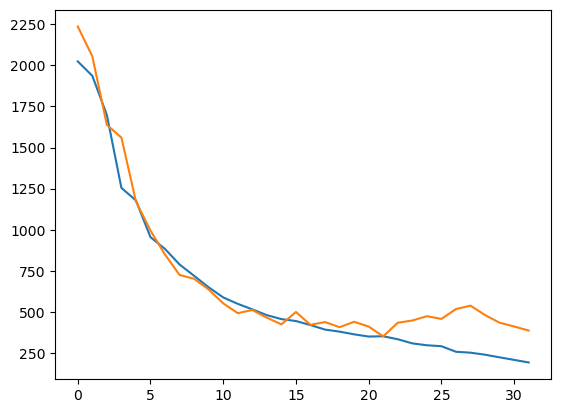

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])